In [1]:
#-*- coding : utf-8 -*-
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from stMMR.utils import *
from stMMR.process import *
from stMMR import train_model
from datetime import datetime

In [2]:
section_id="151509"
k=7

In [3]:
im_re = pd.read_csv(os.path.join('Data/DLPFC/',section_id, "image_representation/ViT_pca_representation.csv"),
                    header=0, index_col=0,sep=',')
print(section_id, k)
input_dir = os.path.join('Data/DLPFC/', section_id)
adata = sc.read_visium(path=input_dir, count_file=section_id+'_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
# prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
adata.obsm["im_re"] = im_re
adata =  adata[:, adata.var['highly_variable']]
Ann_df = pd.read_csv(os.path.join('Data/DLPFC/',
                                  section_id, "cluster_labels_" + section_id + '.csv'), sep=',', header=0, index_col=0)
adata.obs['ground_truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
Ann_df = Ann_df.replace(1, "Layer 1")
Ann_df = Ann_df.replace(2, "Layer 2")
Ann_df = Ann_df.replace(3, "Layer 3")
Ann_df = Ann_df.replace(4, "Layer 4")
Ann_df = Ann_df.replace(5, "Layer 5")
Ann_df = Ann_df.replace(6, "Layer 6")
Ann_df = Ann_df.replace(7, "WM")
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']

151509 7


In [4]:
adata.obsm["adj"] = calculate_adj_matrix(adata)
adata= train_model.train(adata,k,h=[3000,3000],n_epochs=200,enhancement=True)

[2024-09-30 23:32:43] Epoch: 0/200, Loss: 12.3889
[2024-09-30 23:33:09] Epoch: 5/200, Loss: 10.4048
[2024-09-30 23:33:36] Epoch: 10/200, Loss: 8.8526
[2024-09-30 23:34:02] Epoch: 15/200, Loss: 6.0462
[2024-09-30 23:34:28] Epoch: 20/200, Loss: 5.5759
[2024-09-30 23:34:54] Epoch: 25/200, Loss: 5.1756
[2024-09-30 23:35:19] Epoch: 30/200, Loss: 5.0003
[2024-09-30 23:35:45] Epoch: 35/200, Loss: 4.9191
[2024-09-30 23:36:10] Epoch: 40/200, Loss: 4.8497
[2024-09-30 23:36:36] Epoch: 45/200, Loss: 4.8120
[2024-09-30 23:37:02] Epoch: 50/200, Loss: 4.7816
[2024-09-30 23:37:29] Epoch: 55/200, Loss: 4.7585
[2024-09-30 23:37:56] Epoch: 60/200, Loss: 4.7402
[2024-09-30 23:38:22] Epoch: 65/200, Loss: 4.7237
[2024-09-30 23:38:47] Epoch: 70/200, Loss: 4.7128
[2024-09-30 23:39:13] Epoch: 75/200, Loss: 4.6916
[2024-09-30 23:39:39] Epoch: 80/200, Loss: 4.6646
[2024-09-30 23:40:04] Epoch: 85/200, Loss: 4.6357
[2024-09-30 23:40:30] Epoch: 90/200, Loss: 4.6090
[2024-09-30 23:40:54] Epoch: 95/200, Loss: 4.5949


Adjusted rand index = 0.59


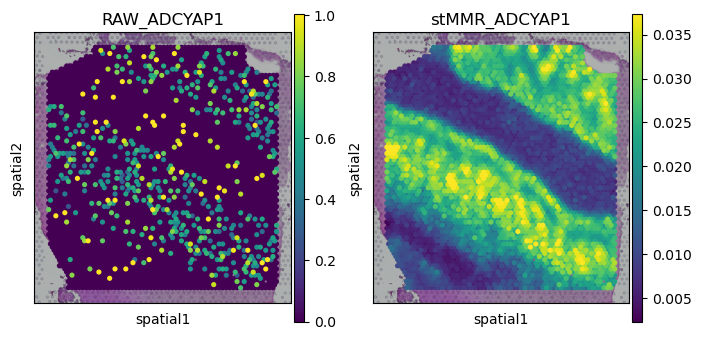

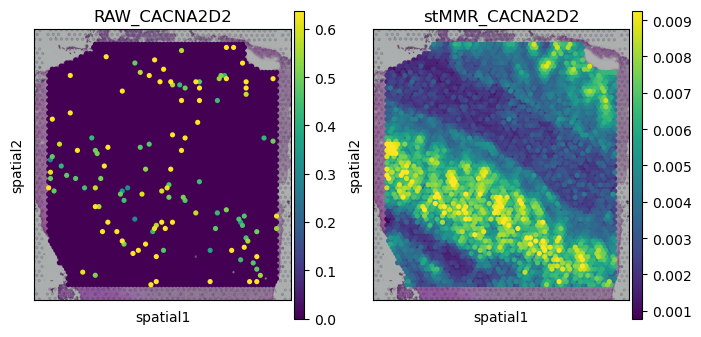

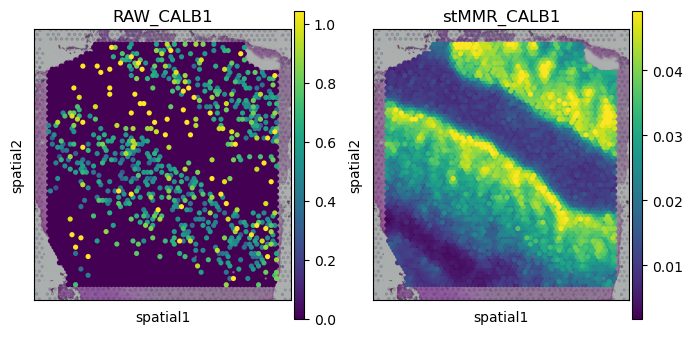

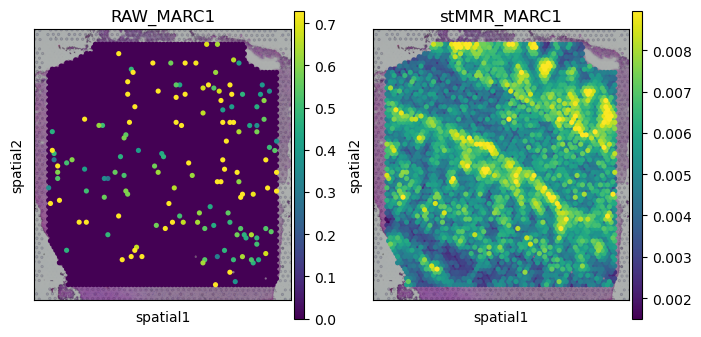

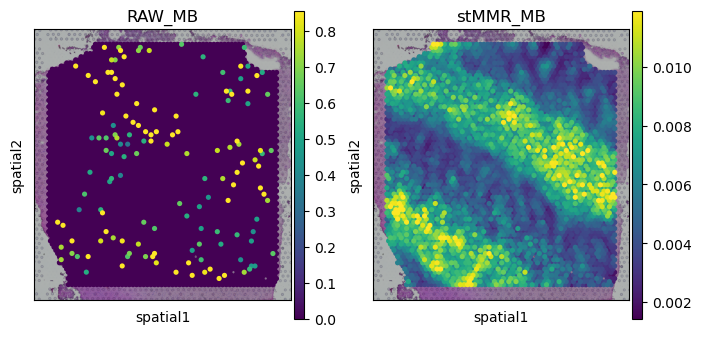

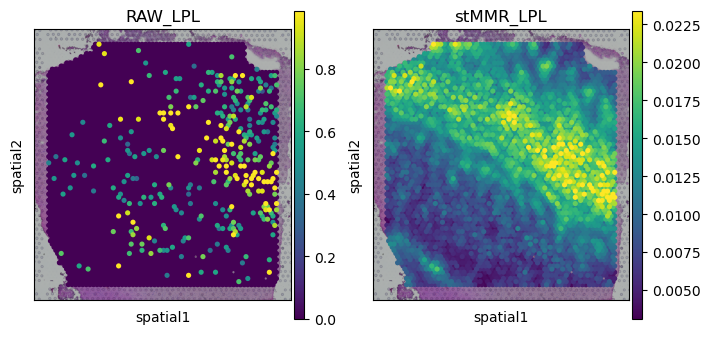

In [5]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['stMMR'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' % ARI)
genelist=["ADCYAP1","CACNA2D2","CALB1","MARC1","MB","LPL"]
for plot_gene in genelist:
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    sc.pl.spatial(adata,spot_size=200, img_key="hires", color=plot_gene, show=False, ax=axs[0], title='RAW_'+plot_gene, vmax='p99')
    sc.pl.spatial(adata,spot_size=200, img_key="hires", color=plot_gene, show=True, ax=axs[1], title='stMMR_'+plot_gene, layer='stMMR', vmax='p99',save=section_id+plot_gene)